In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from constants import SimConstants

## Analysis

In [2]:
i_px = 0
i_py = 1
i_vx = 2
i_vy = 3
i_fx = 4
i_fy = 5
i_pr = 6
i_ps = 7

In [3]:
sconst = sconst = SimConstants.from_file('./data/const_n=500,w=10,v=7.5.json')
data_csv = pd.read_csv('./data/hist_n=500,w=10,v=7.5.csv')
data_csv

,position_x,position_y,velocity_x,velocity_y,force_x,force_y,pressure,person_state
0,33.500000,38.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,49.500000,40.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,27.500000,35.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,24.500000,43.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,30.500000,39.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...
499995,69.705414,38.561854,0.352027,0.409272,-327.959048,-899.856461,24123.445935,0.0
499996,49.584821,44.517273,0.819892,-0.033674,-112.747527,89.102913,1632.425231,0.0
499997,69.543586,40.208884,4.730203,0.198422,0.000000,0.000000,0.000000,1.0
499998,69.709639,36.545641,0.032919,0.118448,-23.144341,-1145.716142,25453.820826,0.0


In [4]:
data_arr = data_csv.to_numpy()
data = data_arr.reshape(sconst.n_time_steps, -1, *data_arr.shape[1:])
print(data.shape)

(1000, 500, 8)


In [5]:
%matplotlib inline

avg_densities = np.zeros(sconst.n_time_steps)
allign_coefs = np.zeros(sconst.n_time_steps)

for t in range(sconst.n_time_steps):
    positions = data[t, :, i_px:i_py+1]
    velocities = data[t, :, i_vx:i_vy+1]
    forces = data[t, :, i_fx:i_fy+1]
    pressures = data[t, :, i_pr]
    person_state = data[t, :, i_ps]

    velocities[person_state > 0] = 0
    
    counts = np.zeros(sconst.n_individuals)
    
    mean_velocity = np.linalg.norm(np.mean(velocities, axis=0))+0.000000001
    sum_velocity = np.sum(velocities/sconst.v_max, axis=0)
    allign_coefs[t] = np.linalg.norm(sum_velocity)
    
    for i in range(sconst.n_individuals):
        circle_rad = 1
        circle_area = circle_rad*np.pi*np.pi
        distances = np.linalg.norm(positions[i] - positions, axis=1)
        counts[i] = np.sum(distances < circle_rad)

    avg_densities[t] = np.mean(counts)/circle_area
    
allign_coefs /= sconst.n_individuals
time_steps = np.arange(sconst.n_time_steps)
        

Text(0.5, 0, 'Time [s]')

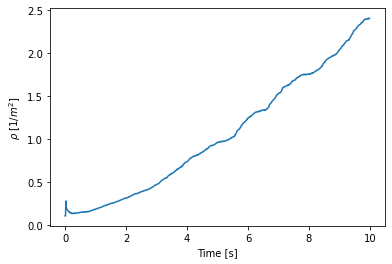

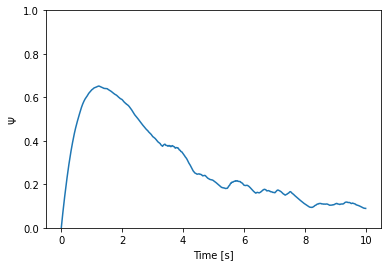

In [6]:
fig = plt.figure()
plt.plot(time_steps * sconst.time_inc, avg_densities)
plt.xlabel("Time [s]")
plt.ylabel(r"$\rho \ [1/m^2]$")

fig = plt.figure()
plt.plot(time_steps[:] * sconst.time_inc, allign_coefs[:])
plt.ylim((0,1))
plt.ylabel(r"$\Psi$")
plt.xlabel("Time [s]")

<IPython.core.display.Javascript object>


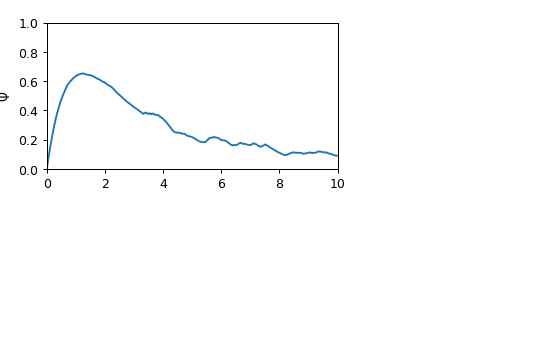

In [9]:
%matplotlib notebook

import matplotlib.animation as anim
writer = anim.PillowWriter()

fig = plt.figure()
xs = []
ys = []
ax = fig.gca()
pt = ax.plot(xs, ys)[0]
ax.set_ylim((0,1))
ax.set_xlim(0, 10)
ax.set_ylabel(r"$\Psi$")
ax.set_xlabel("Time [s]")

def animate(i):
    global pt
        
    pt.set_xdata(time_steps[:i]*sconst.time_inc)
    pt.set_ydata(allign_coefs[:i])

    return pt,

animation = anim.FuncAnimation(fig=fig, func=animate, frames=sconst.n_time_steps, blit=True)
animation.save('gifs/alignment-coef.gif', writer=writer)

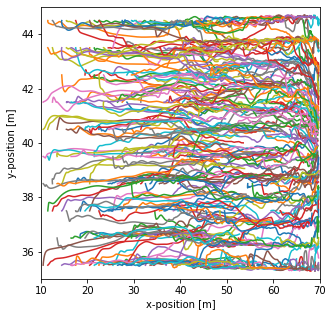

In [12]:
%matplotlib inline

fig = plt.figure(figsize=(5,5))
plt.xlim(sconst.left_inner, sconst.right_inner)
plt.ylim(sconst.bot_inner, sconst.top_inner)
particles = np.arange(300)

plt.xlabel("x-position [m]")
plt.ylabel("y-position [m]")
plt.plot(data[:, particles, 0], data[:, particles, 1]);

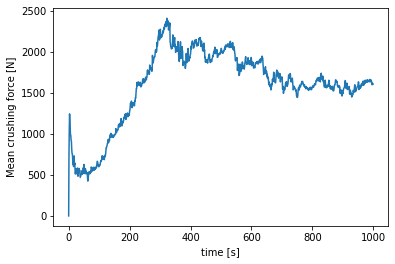

In [14]:
living_states = data[:, :, 7]
pressures = data[living_states==sconst.s_living, 6]
fig = plt.figure()
plt.xlabel("time [s]")
plt.ylabel("Mean crushing force [N]")
plt.plot(time_steps, np.mean(data[:, :, 6], axis=1));

(1000, 500)


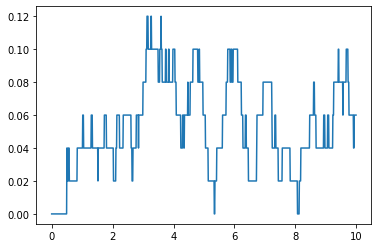

In [15]:
# Number of people leaving as a function of time
living_states = data[:, :, 7]
n_leaving = (living_states == sconst.s_exited).astype(int)
print(n_leaving.shape)
n_leaving_t = n_leaving[1:] - n_leaving[:-1]

n_frames = sconst.n_time_steps
avg_window = 50
n_leaving_t_avg = np.zeros(n_frames)
n_left = np.sum(n_leaving_t, axis=1)
for i in range(avg_window, n_frames):
    window = n_left[i-avg_window:i]
    n_leaving_t_avg[i] = np.mean(window)

plt.plot(np.arange(1000)*sconst.time_inc, n_leaving_t_avg);

C:\Users\gaspa\AppData\Local\Temp\ipykernel_46772\1054493816.py:3: RuntimeWarning: divide by zero encountered in true_divide
  reynold = avg_densities * sconst.v_max * (sconst.right_inner - sconst.left_inner) / n_leaving_t_avg


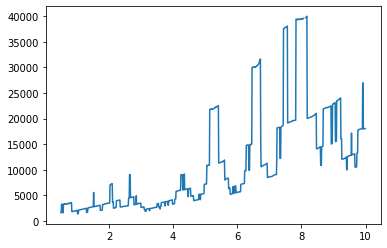

In [17]:
# Reynolds number
#reynold = np.zeros(sconst.n_time_steps)
reynold = avg_densities * sconst.v_max * (sconst.right_inner - sconst.left_inner) / n_leaving_t_avg
plt.plot(np.arange(sconst.n_time_steps)*sconst.time_inc, reynold)

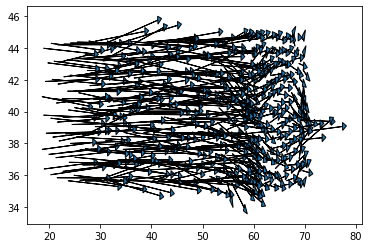

In [18]:


frame = 200

pos_info = data[frame, :, :4]
fig = plt.figure()
ax = fig.gca()
arrow_len = 1.5
for i in range(sconst.n_individuals):
    ax.arrow(pos_info[i, 0], pos_info[i, 1], arrow_len*pos_info[i, 2], arrow_len*pos_info[i, 3], head_width=0.5)
#plt.streamplot(pos_info[unique_xs, 0], pos_info[:, 1], pos_info[:, 2], pos_info[:, 3])



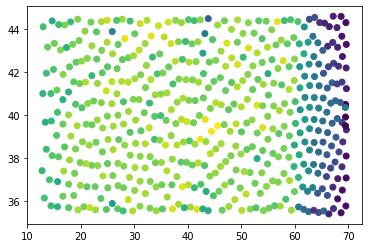

interactive(children=(IntSlider(value=100, description='frame', max=1000), Output()), _dom_classes=('widget-in…

In [19]:
from ipywidgets import interact, interactive

fig = plt.figure()
pos_info = data[100, :, :4]
im = plt.scatter(pos_info[:, 0], pos_info[:, 1], c=np.linalg.norm(pos_info[:, 2:4], axis=1))



@interact(frame=(0, 1000))
def vel_density(frame=100):
    pos_info = data[frame, :, :4]

    im = plt.scatter(pos_info[:, 0], pos_info[:, 1], c=np.linalg.norm(pos_info[:, 2:4], axis=1))
    plt.colorbar(im)



## Rework

In [ ]:
import json

from constants import SimConstants

sconst = SimConstants.from_file('./data/const_n=100,w=8,v=5.json')
data = pd.read_csv('./data/hist_n=100,w=8,v=5.csv')

print(data)